In [1]:
import cv2
import numpy as np
from utils import show_images

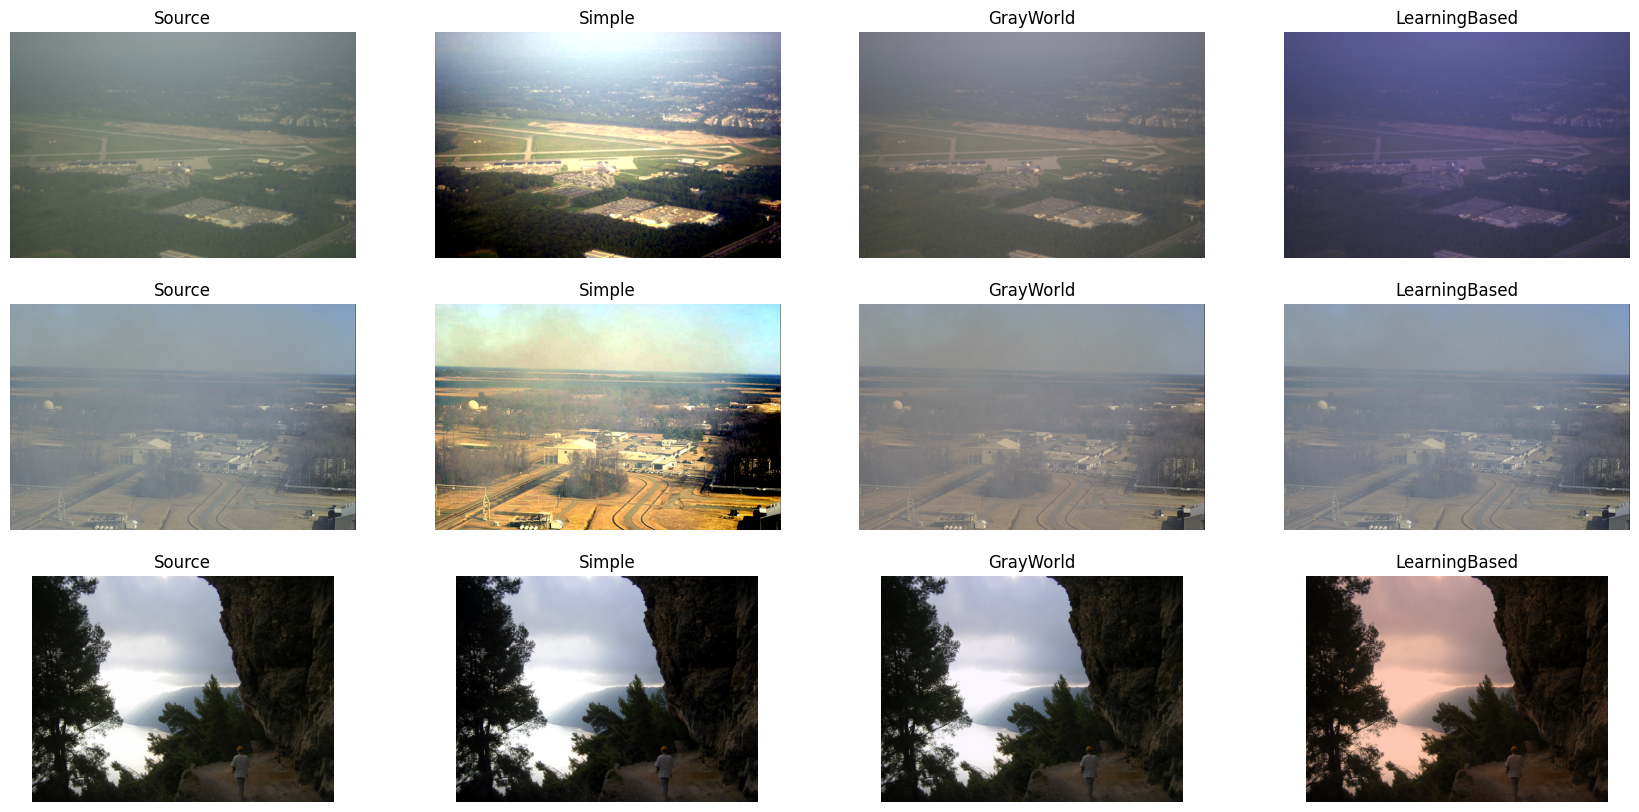

In [3]:
'''
使用三种 AWB 方法
'''

model_0 = cv2.xphoto.createSimpleWB()
# ignores the top and bottom p% of pixel values
model_0.setP(5) 

model_1 = cv2.xphoto.createGrayworldWB()
# 对于像素 i，s[i] < 0.95 才考虑，其中 s[i]=(rgb[i].max - rgb[i].min)/(rgb[i].max)
model_1.setSaturationThreshold(0.8) 

# 可传入 String 参数，表示 .yml 文件路径；不传就用默认参数
model_2 = cv2.xphoto.createLearningBasedWB()

result = []
for i in range(1, 4):
    src = cv2.imread(f'./image/awb/0{i}.png')
    result.append(['Source', src])
    result.append(['Simple', model_0.balanceWhite(src)])
    result.append(['GrayWorld', model_1.balanceWhite(src)])
    result.append(['LearningBased', model_2.balanceWhite(src)])

show_images(result, colnum=4, scale=10)

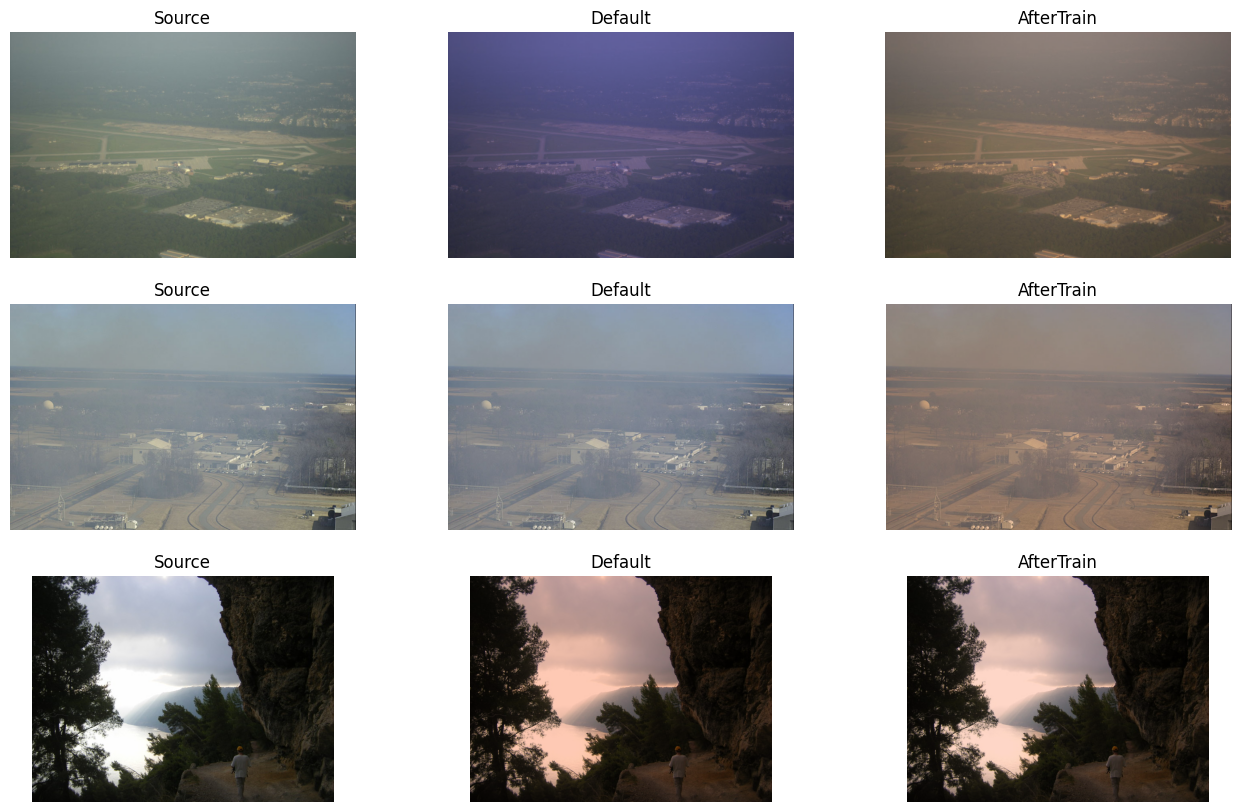

In [2]:
'''
训练 Learning-Based AWB
https://docs.opencv.org/4.x/dc/dcb/tutorial_xphoto_training_white_balance.html
'''

# 可传入 String 参数，表示 .yml 文件路径；不传就用默认参数
model_0 = cv2.xphoto.createLearningBasedWB()
model_1 = cv2.xphoto.createLearningBasedWB('./image/awb/LearningData/color_balance_model.yml')
model_1.setRangeMaxVal(255)
model_1.setSaturationThreshold(0.98)
model_1.setHistBinNum(64)

result = []
for i in range(1, 4):
    src = cv2.imread(f'./image/awb/0{i}.png')
    result.append(['Source', src])
    result.append(['Default', model_0.balanceWhite(src)])
    result.append(['AfterTrain', model_1.balanceWhite(src)])

show_images(result, colnum=3, scale=10)

In [ ]:
# '''
# LearningBasedAWB 训练
# 参考官方的脚本文件，尽量简单化，后面保存文件部分我觉得没必要再抠细节了，就直接照搬了
# https://github.com/opencv/opencv_contrib/tree/master/modules/xphoto/samples/learn_color_balance.py
# '''
# import os
# import cv2
# import scipy
# import random
# import numpy as np
# from sklearn.tree import DecisionTreeRegressor

# def to_8bit(img, pp=2.5):
#     ratio = (255 / np.percentile(img, 100-pp))
#     return (img*ratio).clip(0, 255).astype(np.uint8)

# def apply_gain(data, g):
#     data[..., 0] *= g[0]
#     data[..., 1] *= g[1]
#     data[..., 2] *= g[2]
#     return data

## --------------------------------------------------------------------------------------
## 需要下载文件，Gehler-Shi dataset(http://www.cs.sfu.ca/~colour/data/shi_gehler)
## canno5dfile: 把 cannon5d 的三个压缩包解压，将其中的 PNG 图片放在参数表示的路径中
## gtfile: 把 groundtruth 的压缩包解压，将其中的文件放到对应路径中
## --------------------------------------------------------------------------------------
# datadir = 'code/image/awb/LearningData'
# outfile = 'code/image/awb/LearningData/output.yml'
# canno5dfile = f'{datadir}/png_canon5d'))
# gtfile = f'{datadir}/groundtruth_568/real_illum_568..mat'

# # 一些参数
# num_histbin = 64
# num_trees = 30
# num_augment = 0 # 图片增广，这里的增广操作变形扭曲，而是RGB各自乘上随机数
# train_ratio = 0.8
# max_tree_depth = 6

# # 文件名准备，原来数据集有 Canon1d 和 Canon5d，这里只对 Canon5d 进行操作
# imgnames = sorted(os.listdir(canno5dfile))

# # 读取校正数据，排列顺序 Cannon1d 和 Canno5d，这里只对 Canon5d 进行操作，所以要删掉前面的一些行
# gt = scipy.io.loadmat(gtfile)
# illuminants = gt['real_rgb'][-len(imgnames):]

# # 黑电平数据，根据官网描述，Canon1d 和 Canno5d 分别为 0 和 129，我们只用 5d，所以就是 129
# blacklevel = 129

# # 准备模型
# model = cv2.xphoto.createLearningBasedWB()
# model.setRangeMaxVal(255)
# model.setSaturationThreshold(0.98)
# model.setHistBinNum(num_histbin)

# # 读取训练图片，得到特征和正确结果数据
# gt_illums, features = [], []
# for idx, imgname in enumerate(imgnames):
#     if idx / len(imgnames) > train_ratio:
#         break

#     img = cv2.imread(f'{datadir}/png_canon5d/{imgname}', -1)
#     img = img.astype(np.float32) - blacklevel

#     # 一张训练图片和其增广后的图片，这里的增广就是改变图片各个通道颜色
#     gains = [[1, 1, 1]]
#     for _ in range(num_augment):
#         gains.append([random.uniform(0.2, 2.0) for _ in range(3)])

#     for one_gain in gains:
#         # gainB, gainG, gainR = one_gain
#         nowimg = apply_gain(img, one_gain)

#         img_8bit = to_8bit(nowimg, pp=2.5)
#         features.append(list(model.extractSimpleFeatures(img_8bit)))

#         # 注意 GroundTruth 里面是 RGB
#         nowillum = apply_gain(illuminants[idx], one_gain[::-1])
#         gt_illums.append(list(nowillum))

# # 最终 features.shape = (图片数量 * 每张图片扩展成几张, extractSimpleFeatures(img).shape)
# # extractSimpleFeatures(img).shape = (feature_types, 1, ?)
# features, gt_illums = np.array(features), np.array(gt_illums)

# # 即当前的 extractSimpleFeature 提取一张图片特征时提取多少种类
# feature_types = features.shape[1]

# # 上面每一张图片有特征和正确数据，现在整理一下，按照 正确数据中红色占比 来排列
# eps = 0.001
# pos = np.argsort([illum[0]/(sum(illum)+eps) for illum in gt_illums])

# # 开始训练，训练 num_trees 个树，所以把数据分开来各自训练。
# partition_size = int(len(gt_illums)) / (num_trees+1)
# trees = []
# for tree_idx in range(num_trees):
#     # 但其实不是有 n 个树就分 n 份，其实每份之间有交叉，如这里就是训练一棵树用三份数据
#     lo = tree_idx * partition_size
#     hi = (tree_idx + 2) * partition_size

#     # 遍历 features 和 gt_illums
#     X, y_r, y_g = [], [], []
#     for idx in range(len(gt_illums)):
#         # weight = num_trees if lo<pos[idx]<hi else 1
#         weight = 1
#         X.append(features[idx] * weight)
#         y_r.append(gt_illums[idx][0] / (sum(gt_illums[idx]) + eps) * weight)
#         y_g.append(gt_illums[idx][1] / (sum(gt_illums[idx]) + eps) * weight)

#     X, y_r, y_g = np.array(X), np.array(y_r), np.array(y_g)

#     # 训练，feature 有多类特征，每类特征都要训练
#     now_tree = []
#     for feature_idx in range(feature_types):
#         tree_r = DecisionTreeRegressor(max_depth = max_tree_depth, random_state = 1234)
#         tree_r.fit(X[:, feature_idx, 0], y_r)
#         tree_g = DecisionTreeRegressor(max_depth = max_tree_depth, random_state = 1234)
#         tree_g.fit(X[:, feature_idx, 0], y_g)
#         now_tree.append([tree_r, tree_g])
#     trees.append(now_tree)


# # 保存文件
# def get_tree_node_lists(tree, tree_depth):
#     dst_feature_idx = (2**tree_depth-1) * [0]
#     dst_thresh_vals = (2**tree_depth-1) * [.5]
#     dst_leaf_vals   = (2**tree_depth) * [-1]
#     leaf_idx_offset = (2**tree_depth-1)
#     left      = tree.tree_.children_left
#     right     = tree.tree_.children_right
#     threshold = tree.tree_.threshold
#     value = tree.tree_.value
#     feature = tree.tree_.feature

#     def recurse(left, right, threshold, feature, node, dst_idx, cur_depth):
#         if (threshold[node] != -2):
#             dst_feature_idx[dst_idx] = feature[node]
#             dst_thresh_vals[dst_idx] = threshold[node]
#             if left[node] != -1:
#                 recurse (left, right, threshold, feature, left[node], 2*dst_idx+1, cur_depth + 1)
#             if right[node] != -1:
#                 recurse (left, right, threshold, feature, right[node], 2*dst_idx+2, cur_depth + 1)
#         else:
#             lo = 2**(tree_depth - cur_depth) * dst_idx + (2**(tree_depth - cur_depth) - 1) - leaf_idx_offset
#             hi = 2**(tree_depth - cur_depth) * dst_idx + (2**(tree_depth - cur_depth+1) - 2) - leaf_idx_offset + 1
#             dst_leaf_vals[lo:hi] = (hi - lo) * [value[node][0][0]]

#     recurse(left, right, threshold, feature, 0, 0, 0)
#     return (dst_feature_idx, dst_thresh_vals, dst_leaf_vals)

# feature_idx, thresh_vals, leaf_vals = [], [], []
# for now_tree in trees:
#     # now_tree_r, now_tree_g = now_tree
#     for now_tree_c in now_tree:
#         result = get_tree_node_lists(now_tree_c[0], max_tree_depth)
#         local_feature_idx, local_thresh_vals, local_leaf_vals = result
#         feature_idx += local_feature_idx
#         thresh_vals += local_thresh_vals
#         leaf_vals += local_leaf_vals

#         result = get_tree_node_lists(now_tree_c[1], max_tree_depth)
#         local_feature_idx, local_thresh_vals, local_leaf_vals = result
#         feature_idx += local_feature_idx
#         thresh_vals += local_thresh_vals
#         leaf_vals += local_leaf_vals

# fs = cv2.FileStorage(outfile, 1)
# fs.write("num_trees", num_trees)
# fs.write("num_tree_nodes", 2**max_tree_depth)
# fs.write("feature_idx", np.array(feature_idx).astype(np.uint8))
# fs.write("thresh_vals", np.array(thresh_vals).astype(np.float32))
# fs.write("leaf_vals", np.array(leaf_vals).astype(np.float32))
# fs.release()